In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(7,5)
# Add the application folder to the path
import sys
sys.path.insert(0,'../Peergrade/peergrade/')
import time
import math
from application.model import data_model
from matplotlib.backends.backend_pdf import PdfPages
from collections import defaultdict
import numpy as np
from bson.objectid import ObjectId
from matplotlib import pyplot as plt
from scipy.stats.stats import pearsonr
from scipy.stats import norm

SERVER_NAME: localhost:5000


In [2]:
fig_store = "../MasterThesis/Thesis/figures/Analysis/"

In [317]:
class Grader_(object):
    def __init__(self, id):
        self.id = id
        self.handins = list()
        
    def add_handin(self, handin):
        self.handins.append(handin)
                
class Question_(object):
    def __init__(self,id):
        self.id = id
                
class Answers_(object):
    def __init__(self,handin,question):
        self.handin = handin
        self.question = question
        self.answers = dict()
    
class Handin_(object):
    def __init__(self,id,owner):
        self.id = id
        self.owner = owner
        self.gradeings = dict()
        self.graders = list()
        self.catched_score = dict()
            
    def add_grader(self,grader):
        self.graders.append(grader)
        
    def add_answer(self,grader,question,value):
        if str(question.id) not in self.gradeings:
            self.gradeings[str(question.id)] = Answers_(self,question)
        self.gradeings[str(question.id)].answers[str(grader.id)] = value
        
    def get_graders_answers(self):
        graders_answers = defaultdict(list)
        for q, answer in self.gradeings.iteritems():
            for g, answer in answer.answers.iteritems():
                graders_answers[str(g)].append((str(q),answer))
            
        return graders_answers
        
    def get_grader_answers(self,grader):
        grader_answers = list()
        for grader in self.graders:
            grader_answers.append((key,values[grader.id]))
        return grader_answers
    
    def get_handin_score(self,g):
        if g not in self.catched_score:
            grader_g = list()
            for answers in self.gradeings.itervalues():
                if g not in  answers.answers:
                    return None
                grader_g.append(answers.answers[g])
            self.catched_score[g] = np.mean(grader_g)
        
        return self.catched_score[g]

class Assignment_(object):
    
    def __init__(self, handins_input, graders_input, questions_input, n_gradings):
        self.graders = dict()
        self.handins = dict()
        self.questions = dict()
        self.n_gradings = n_gradings
        for handin in handins_input:
            self.handins[str(handin.id)] = handin
        for grader in graders_input:
            self.graders[str(grader.id)] = grader
        for question in questions_input:
            self.questions[str(question.id)] = question

    def add_handin(self, handin):
        self.handing[str(handin.id)] = handin
        
    def add_grader(self, grader):
        self.graders[str(grader.id)] = grader
    
    def set_questions(self, questions):
        self.questions = list(questions)

In [4]:
def user_name(user_id):
    user = data_model.User.objects.get(id=user_id)
    return user.name

def user_id(user_name):
    for user in data_model.User.objects(name=user_name):
        return user.id

def question_text(q_id):
    user = data_model.Question.objects.get(id=ObjectId(q_id))
    return user.text

def question_max_value(question):
    if question.question_type == "boolean":
        return 1
    elif question.question_type == "numerical":
        if question.numericalAnswers:
            return max(map(int,question.numericalAnswers.keys()))
        else:
            return 1

def answer_value(answer):
    if answer.numerical_answer != None:
        return answer.numerical_answer / float(question_max_value(answer.question))
    if answer.boolean_answer != None:
        return answer.boolean_answer / float(question_max_value(answer.question))

def answeres_handin(report_grade):
    '''Returns a list of tuples containing the answer and the value of the question'''
    answers = data_model.Answer.objects(report_grade=report_grade)
    result = list()
    for answer in answers:
        if answer.numerical_answer != None or answer.boolean_answer != None:
            result.append((answer,answer_value(answer)))
    return result

In [5]:
def fetch_assignment_data(ass_obj):
    '''
    Takes an course and assignment data model object and transforms it into populated Assignment object
    Only student or all?
    '''

    print ass_obj.id
    
    ## Make dictionary to hold all the graders who have graded a handin
    graders = dict()
    
    ## Find all relevant question for the assignemnt
    questions = dict()
    for sec in ass_obj.sections:
        for question in sec.questions:
            if question.question_type != 'text':
                questions[str(question.id)] = Question_(str(question.id))
    
    ## Find all handins
    handins = dict()
    for handin_ in data_model.Handin.objects(assignment=ass_obj):
        handins[str(handin_.id)] = Handin_(str(handin_.id),str(handin_.submitter.id))    
        
    ## Find all handins graders have graded and vice versa
    n_gradings = 0
    for handin_ in data_model.Handin.objects(assignment=ass_obj):
        for grade in data_model.ReportGrade.objects(handin=handin_,state='ANSWERED'):
            
            n_gradings = n_gradings + 1
            
            # Needed if TA or Professor have graded reports as they are not initialy part of it
            if str(grade.giver.id) not in graders:
                graders[str(grade.giver.id)] = Grader_(str(grade.giver.id))
                
            handins[str(handin_.id)].add_grader(graders[str(grade.giver.id)])
            
            ## Find all answers to each question
            for answer, answer_value in answeres_handin(grade):
                if str(answer.question.id) in questions:
                    handins[str(handin_.id)].add_answer(grade.giver,answer.question,answer_value)
            
    ## update reference in graders
    for handin in handins.itervalues():
        for grader in handin.graders:
            grader.add_handin(handin)

    return Assignment_(handins.itervalues(),graders.itervalues(),questions.itervalues(),n_gradings)

In [284]:
def gibbs_model(data, samples, burn_in=0):
    
    # Counts
    N_H = len(data.handins) # Number of handins
    N_G = len(data.graders) # Number of graders
    N_Q = len(data.questions) # Number of graders
    N_g = data.n_gradings   # Number of gradings
    N_eval = N_g*N_G   # Number of evaluations in total
    
    # Hyperparameters
    ga_h = 0.5
    la_h = 1.0
    al_h = 10.0
    be_h = 0.1

    ga_g = 0.0
    la_g = 1.0
    al_g = 50.0
    be_g = 0.1
    
    al_n = 10.0
    be_n = 1.0
        
    # Prior parameters
    u_h = dict()
    t_h = dict()
    u_g = dict()
    t_g = dict()
    T = dict()
    B = dict()

    # Draw from priors
    n_v = np.random.gamma(al_n,1.0/be_n)
    for h in data.handins.iterkeys():
        t_h[h] = np.random.gamma(al_h,1.0/be_h)
        u_h[h] = np.random.normal(ga_h,np.sqrt(1.0/(la_h * t_h[h])))
        T[h] = np.random.normal(u_h[h],np.sqrt(1.0/t_h[h]))
    for g in data.graders.iterkeys():
        t_g[g] = np.random.gamma(al_g,1.0/be_g)
        u_g[g] = np.random.normal(ga_g,np.sqrt(1.0/(la_g * t_g[g])))
        B[g] = np.random.normal(u_g[g],np.sqrt(1.0/t_g[g]))
            
    # Gibbs sampling #
    
    # Tracers initialising
    acc_n_v = list()
    acc_u_h = defaultdict(list)
    acc_t_h = defaultdict(list)
    acc_u_g = defaultdict(list)
    acc_t_g = defaultdict(list)
    acc_T = defaultdict(list)
    acc_B = defaultdict(list)

    tw = time.time()
    for r in range(burn_in + samples):
        print "\r%i" % (r+1) + " out of %i" % (burn_in + samples),
        
        # Sample T
        for h, handin in data.handins.iteritems():
            n_gradings = 0.0
            sum_ = 0.0
            for g in handin.graders:
                val = handin.get_handin_score(g.id)
                if val <> None:
                    n_gradings = n_gradings + 1.0
                    sum_ = sum_ + val - B[g.id]
            v = n_v*n_gradings+t_h[h]
            T[h] = np.random.normal((u_h[h]*t_h[h]+n_v*sum_)/v,np.sqrt(1.0/v))

        # Sample B
        for g, grader in data.graders.iteritems():
            n_gradings = 0.0
            sum_ = 0.0
            for handin in grader.handins:
                val = handin.get_handin_score(g)
                if val <> None:
                    n_gradings = n_gradings + 1.0
                    sum_ = sum_ + val - T[handin.id]
            v = n_v*n_gradings+t_g[g]
            B[g] = np.random.normal((u_g[g]*t_g[g]+n_v*sum_)/v,np.sqrt(1.0/v))

        # Sample e
        sum_ = 0.0
        n_eval = 0
        for h, handin in data.handins.iteritems():
            for grader in handin.graders:
                val = handin.get_handin_score(grader.id)
                if val <> None:
                    n_eval = n_eval + 1
                    sum_ = sum_ + np.square(val - (T[h]+B[grader.id]))
        n_v = np.random.gamma(al_n+0.5*n_eval,1.0 / (be_n+0.5*sum_))

        # Sample u_h and t_h
        for h in data.handins.iterkeys():
            la_ = (la_h+1.0)
            al_ = al_h+0.5
            be_ = be_h+0.5*((la_h*np.square(T[h]-ga_h))/la_)
            t_h[h] = np.random.gamma(al_,1.0/be_)
            u_h[h] = np.random.normal((la_h*ga_h+T[h])/la_,np.sqrt(1.0 / (la_*t_h[h])))

        
        # Sample u_g and t_g
        for g in data.graders.iterkeys():
            la_ = (la_g+1.0)
            al_ = al_g+0.5
            be_ = be_g+0.5*((la_g*np.square(B[g]-ga_g))/la_)
            t_g[g] = np.random.gamma(al_,1.0/be_)
            u_g[g] = np.random.normal((la_g*ga_g+B[g])/la_,np.sqrt(1.0 / (la_*t_g[g])))
                        
        # Collect tracings
        if r > burn_in:
            acc_n_v.append(n_v)
            for h in data.handins.iterkeys():
                acc_u_h[h].append(u_h[h])
                acc_t_h[h].append(t_h[h])
                acc_T[h].append(T[h])
            for g in data.graders.iterkeys():
                acc_u_g[g].append(u_g[g])
                acc_t_g[g].append(t_g[g]) 
                acc_B[g].append(B[g])
                    
    print
    print "Wall time: %f" % (time.time() - tw)
    
    traces = {'n_v' : acc_n_v,
              'u_h' : acc_u_h,
              't_h' : acc_t_h,
              'u_g' : acc_u_g,
              't_g' : acc_t_g,
              'T' : acc_T,
              'B' : acc_B}

    return traces

In [ ]:
def gibbs_model(data, samples, burn_in=0):
    
    # Counts
    N_H = len(data.handins) # Number of handins
    N_G = len(data.graders) # Number of graders
    N_Q = len(data.questions) # Number of graders
    N_g = data.n_gradings   # Number of gradings
    N_eval = N_g*N_G   # Number of evaluations in total
    
    # Hyperparameters
    ga_h = 0.5
    la_h = 1.0
    al_h = 10.0
    be_h = 0.1

    ga_g = 0.0
    la_g = 1.0
    al_g = 50.0
    be_g = 0.1
    
    al_n = 10.0
    be_n = 1.0
        
    # Prior parameters
    u_h = dict()
    t_h = dict()
    u_g = dict()
    t_g = dict()
    T = dict()
    B = dict()

    # Draw from priors
    n_v = np.random.gamma(al_n,1.0/be_n)
    for h in data.handins.iterkeys():
        t_h[h] = np.random.gamma(al_h,1.0/be_h)
        u_h[h] = np.random.normal(ga_h,np.sqrt(1.0/(la_h * t_h[h])))
        T[h] = np.random.normal(u_h[h],np.sqrt(1.0/t_h[h]))
    for g in data.graders.iterkeys():
        t_g[g] = np.random.gamma(al_g,1.0/be_g)
        u_g[g] = np.random.normal(ga_g,np.sqrt(1.0/(la_g * t_g[g])))
        B[g] = np.random.normal(u_g[g],np.sqrt(1.0/t_g[g]))
            
    # Gibbs sampling #
    
    # Tracers initialising
    acc_n_v = list()
    acc_u_h = defaultdict(list)
    acc_t_h = defaultdict(list)
    acc_u_g = defaultdict(list)
    acc_t_g = defaultdict(list)
    acc_T = defaultdict(list)
    acc_B = defaultdict(list)

    tw = time.time()
    for r in range(burn_in + samples):
        print "\r%i" % (r+1) + " out of %i" % (burn_in + samples),
        
        # Sample T
        for h, handin in data.handins.iteritems():
            n_gradings = 0.0
            sum_ = 0.0
            for g in handin.graders:
                val = handin.get_handin_score(g.id)
                if val <> None:
                    n_gradings = n_gradings + 1.0
                    sum_ = sum_ + val - B[g.id]
            v = n_v*n_gradings+t_h[h]
            T[h] = np.random.normal((u_h[h]*t_h[h]+n_v*sum_)/v,np.sqrt(1.0/v))

        # Sample B
        for g, grader in data.graders.iteritems():
            n_gradings = 0.0
            sum_ = 0.0
            for handin in grader.handins:
                val = handin.get_handin_score(g)
                if val <> None:
                    n_gradings = n_gradings + 1.0
                    sum_ = sum_ + val - T[handin.id]
            v = n_v*n_gradings+t_g[g]
            B[g] = np.random.normal((u_g[g]*t_g[g]+n_v*sum_)/v,np.sqrt(1.0/v))

        # Sample e
        sum_ = 0.0
        n_eval = 0
        for h, handin in data.handins.iteritems():
            for grader in handin.graders:
                val = handin.get_handin_score(grader.id)
                if val <> None:
                    n_eval = n_eval + 1
                    sum_ = sum_ + np.square(val - (T[h]+B[grader.id]))
        n_v = np.random.gamma(al_n+0.5*n_eval,1.0 / (be_n+0.5*sum_))

        # Sample u_h and t_h
        for h in data.handins.iterkeys():
            la_ = (la_h+1.0)
            al_ = al_h+0.5
            be_ = be_h+0.5*((la_h*np.square(T[h]-ga_h))/la_)
            t_h[h] = np.random.gamma(al_,1.0/be_)
            u_h[h] = np.random.normal((la_h*ga_h+T[h])/la_,np.sqrt(1.0 / (la_*t_h[h])))

        
        # Sample u_g and t_g
        for g in data.graders.iterkeys():
            la_ = (la_g+1.0)
            al_ = al_g+0.5
            be_ = be_g+0.5*((la_g*np.square(B[g]-ga_g))/la_)
            t_g[g] = np.random.gamma(al_,1.0/be_)
            u_g[g] = np.random.normal((la_g*ga_g+B[g])/la_,np.sqrt(1.0 / (la_*t_g[g])))
                        
        # Collect tracings
        if r > burn_in:
            acc_n_v.append(n_v)
            for h in data.handins.iterkeys():
                acc_u_h[h].append(u_h[h])
                acc_t_h[h].append(t_h[h])
                acc_T[h].append(T[h])
            for g in data.graders.iterkeys():
                acc_u_g[g].append(u_g[g])
                acc_t_g[g].append(t_g[g]) 
                acc_B[g].append(B[g])
                    
    print
    print "Wall time: %f" % (time.time() - tw)
    
    traces = {'n_v' : acc_n_v,
              'u_h' : acc_u_h,
              't_h' : acc_t_h,
              'u_g' : acc_u_g,
              't_g' : acc_t_g,
              'T' : acc_T,
              'B' : acc_B}

    return traces

In [227]:
def gibbs_e_model(data, samples, burn_in=0):
    
    # Counts
    N_H = len(data.handins) # Number of handins
    N_G = len(data.graders) # Number of graders
    N_Q = len(data.questions) # Number of graders
    N_g = data.n_gradings   # Number of gradings
    N_eval = N_g*N_G   # Number of evaluations in total
    
    # Hyperparameters
    ga_h = 0.5
    la_h = 1.0
    al_h = 10.0
    be_h = 0.1

    ga_g = 0.0
    la_g = 1.0
    al_g = 50.0
    be_g = 0.1
    
    al_n = 10.0
    be_n = 1.0
    
    # Prior parameters
    u_h = dict()
    t_h = dict()
    T = defaultdict(dict)
    B = defaultdict(dict)
    u_g = dict()
    t_g = dict()

    # Draw from priors
    n_v = np.random.gamma(al_n,1.0/be_n)
    for h in data.handins.iterkeys():
        t_h[h] = np.random.gamma(al_h,1.0/be_h)
        u_h[h] = np.random.normal(ga_h,np.sqrt(1.0/(la_h * t_h[h])))
        for q in data.questions.iterkeys():        
            T[h][q] = np.random.normal(u_h[h],np.sqrt(1.0/t_h[h]))
    for g in data.graders.iterkeys():
        t_g[g] = np.random.gamma(al_g,1.0/be_g)
        u_g[g] = np.random.normal(ga_g,np.sqrt(1.0/(la_g * t_g[g])))
        for q in data.questions.iterkeys():
            B[str(g)][str(q)] = np.random.normal(u_g[g],np.sqrt(1.0/t_g[g]))
            
    # Gibbs sampling #
    
    # Tracers initialising
    acc_n_v = list()
    acc_u_h = defaultdict(list)
    acc_t_h = defaultdict(list)
    acc_u_g = defaultdict(list)
    acc_t_g = defaultdict(list)
    acc_T = defaultdict(lambda: defaultdict(list))
    acc_B = defaultdict(lambda: defaultdict(list))

    tw = time.time()
    for r in range(burn_in + samples):
        print "\r%i" % (r+1) + " out of %i" % (burn_in + samples),
        # Sample T
        for h, handin in data.handins.iteritems():
            for q, answers in handin.gradeings.iteritems():
                n_gradings = len(answers.answers)
                sum_ = 0.0
                for g, val in answers.answers.iteritems():
                    sum_ = sum_ + val - B[str(g)][str(q)]
                v = n_v*n_gradings+t_h[h]
                T[h][q] = np.random.normal((u_h[h]*t_h[h]+n_v*sum_)/v,np.sqrt(1.0/v))
            
        # Sample B
        for g, grader in data.graders.iteritems():
            for q in data.questions.iterkeys():
                n_gradings = len(grader.handins)
                sum_ = 0.0
                for h in grader.handins:
                    if g in h.gradeings[q].answers:
                        sum_ = sum_ + h.gradeings[q].answers[g] - T[h.id][q]
                v = n_v * n_gradings + t_g[g]
                B[g][q] = np.random.normal((u_g[g]*t_g[g]+n_v*sum_)/v,np.sqrt(1.0/v))
        
        # Sample e
        sum_ = 0.0
        n_eval = 0
        for h, handin in data.handins.iteritems():
            for q, answers in handin.gradeings.iteritems():
                for g, answer_val in answers.answers.iteritems():
                    n_eval = n_eval + 1
                    sum_ = sum_ + np.square(answer_val - (T[h][q]+B[g][q]))
        n_v = np.random.gamma(al_n+0.5*n_eval,1.0 / (be_n+0.5*sum_))

        # Sample u_q and t_q
        for h in data.handins.iterkeys():
            la_ = (la_h+N_Q)
            sum_q = np.sum(T[h].values())
            mean_q = sum_q / N_Q
            sum_minus = 0.0
            for q in data.questions.iterkeys():
                sum_minus = sum_minus + np.square(T[h][q]-mean_q)
            al_ = al_h+0.5*N_Q
            be_ = be_h+0.5*(N_Q*sum_minus+(N_Q*la_h*np.square(mean_q-ga_h))/la_)
            t_h[h] = np.random.gamma(al_,1.0 / be_)
            u_h[h] = np.random.normal((la_h*ga_h+sum_q)/la_,np.sqrt(1.0/(la_*t_h[h])))

        # Sample u_g and t_g
        for g in data.graders.iterkeys():
            la_ = (la_g+N_Q)
            sum_q = np.sum(B[g].values())
            mean_q = sum_q / N_Q
            sum_minus = 0.0
            for q in data.questions.iterkeys():
                sum_minus = sum_minus + np.square(B[g][q]-mean_q)
            al_ = al_g+0.5*N_Q
            be_ = be_g+0.5*(N_Q*sum_minus+(N_Q*la_g*np.square(mean_q-ga_g))/la_)
            t_g[g] = np.random.gamma(al_,1.0 / be_)
            u_g[g] = np.random.normal((la_g*ga_g+sum_q)/la_,np.sqrt(1.0/(la_*t_g[g])))
                        
        # Collect tracings
        if r > burn_in:
            acc_n_v.append(n_v)
            for h in data.handins.iterkeys():
                acc_u_h[h].append(u_h[h])
                acc_t_h[h].append(t_h[h])
                for q in data.questions.iterkeys():
                    acc_T[h][q].append(T[h][q])
            for g in data.graders.iterkeys():
                acc_u_g[g].append(u_g[g])
                acc_t_g[g].append(t_g[g])
                for q in data.questions.iterkeys():
                    acc_B[g][q].append(B[g][q])
                    
    print
    print "Wall time: %f" % (time.time() - tw)
    
    traces = {'n_v' : acc_n_v,
              'u_h' : acc_u_h,
              't_h' : acc_t_h,
              'u_g' : acc_u_g,
              't_g' : acc_t_g,
              'T' : acc_T,
              'B' : acc_B}

    return traces

In [7]:
def norm_log_pdf(x,u,t):
    return -0.5*t*(x-u)**2+np.log(t)-np.log(np.sqrt(2.0*math.pi))

def gamma_log_pdf(x,a,b):
    return a*np.log(b)-np.log(math.gamma(a))+(a-1.0)*np.log(x)-b*x

def norm_gamma_log_pdf(u,t,ga,la,a,b):
    return a*np.log(b)+np.log(np.sqrt(la))-np.log(math.gamma(a))-np.log(np.sqrt(2.0*math.pi))+(a-1)*np.log(t)-np.log(b*t)-0.5*t*la*(u-ga)**2

In [93]:
def MH_model(data,samples,burn_in=0):

    # Counts
    N_H = len(data.handins) # Number of handins
    N_G = len(data.graders) # Number of graders
    N_g = data.n_gradings   # Number of gradings
    N_eval = N_g*N_G   # Number of evaluations in total
    
    # Hyperparameters
    ga_h = 0.5
    la_h = 1.0
    al_h = 10.0
    be_h = 0.1

    ga_g = 0.0
    la_g = 1.0
    al_g = 50.0
    be_g = 0.1
    
    al_e = 10.0
    be_e = 1.0
    t_h = 500.0
    t_g = 100.0
    
    # Prior parameters
    u_h = dict()
    t_h = dict()
    u_g = dict()
    t_g = dict()
    
    log_h = dict()
    log_g = dict()

    def prop_u_t_h(handin,u_h,t_h):
        sum_ = 0.0
        for g in handin.graders.iterkeys():
            val = handin.get_handin_score(g)
            if val <> None:
                sum_ = sum_ + norm_log_pdf(val,u_g[g]+u_h,t_g[g]+t_h)
        return sum_ + norm_gamma_log_pdf(u_h,t_h,ga_h,la_h,al_h,be_h)
    
    def prop_u_t_g(grader,g,u_g,t_g):
        sum_ = 0.0
        for h in grader.handins:
            val = h.get_handin_score(g)
            if val <> None:
                sum_ = sum_ + norm_log_pdf(val,u_g+u_h[h.id],t_g+t_h[h.id])
        return sum_ + norm_gamma_log_pdf(u_g,t_g,ga_g,la_g,al_g,be_g)

    
    # Draw from priors
    for h in data.handins.iterkeys():
        t_h[h] = np.random.gamma(al_h,1/be_h)
        u_h[h] = np.random.normal(ga_h,np.sqrt(1/(la_g * t_h[h])))
    for g in data.graders.iterkeys():
        t_g[g] = np.random.gamma(al_g,1/be_g)
        u_g[g] = np.random.normal(ga_g,np.sqrt(1/(la_g * t_g[g]))) 
    # pre calcuate the liklyhood
    for h, handin in data.handins.iteritems():
        log_h[h] = prop_u_t_h(handin,u_h[h],t_h[h])
    for g, grader in data.graders.iteritems():
        log_g[g] = prop_u_t_g(grader,g,u_g[g],t_g[g])
            
    # Tracers initialising
    trace_u_h = defaultdict(list)
    trace_t_h = defaultdict(list)
    trace_u_g = defaultdict(list)
    trace_t_g = defaultdict(list)
    
    tw = time.time()
    for r in range(burn_in + samples):
        print "\r%i" % (r+1) + " out of %i" % (burn_in + samples),
        
        # Sample u_h and t_h
        for h, handin in data.handins.iteritems():
            # Propose new candidates
            u_h_c = np.random.normal(u_h[h],0.1)
            t_h_c = np.random.normal(t_h[h],0.1)
            #draw from gamma
            p_ = prop_u_t_h(handin,u_h_c,t_h_c)
            alpha = min(1,p_-log_h[h])
            if np.log(np.random.random()) <= alpha:
                u_h[h] = u_h_c
                t_h[h] = t_h_c
                log_h[h] = p_
                    
        # Sample u_g and t_g
        for g, grader in data.graders.iteritems():
            # Propose new candidates
            u_g_c = np.random.normal(u_g[g],0.1)
            t_g_c = np.random.normal(t_g[g],0.1)
            #draw from gamma
            p_ = prop_u_t_g(grader,g,u_g_c,t_g_c)
            alpha = min(1,p_-log_g[g])
            if np.log(np.random.random()) <= alpha:
                u_g[g] = u_g_c
                t_g[g] = t_g_c    
                log_g[g] = p_

        # Collect tracings
        if r > burn_in:
            for h in data.handins.iterkeys():
                trace_u_h[h].append(u_h[h])
                trace_t_h[h].append(t_h[h])
            for g in data.graders.iterkeys():
                trace_u_g[g].append(u_g[g])
                trace_t_g[g].append(t_g[g])
                
    print
    print "Wall time: %f" % (time.time() - tw)
    
    
    traces = {'u_h' : trace_u_h,
              't_h' : trace_t_h,
              'u_g' : trace_u_g,
              't_g' : trace_t_g}

    return traces

In [138]:
def MH_e2_model(data,samples,burn_in=0):

    # Counts
    N_H = len(data.handins) # Number of handins
    N_G = len(data.graders) # Number of graders
    N_g = data.n_gradings   # Number of gradings
    N_eval = N_g*N_G   # Number of evaluations in total
    
    # Hyperparameters
    ga_h = 0.5
    la_h = 1.0
    al_h = 10.0
    be_h = 0.1

    ga_g = 0.0
    la_g = 1.0
    al_g = 50.0
    be_g = 0.1
    
    al_e = 10.0
    be_e = 1.0
    t_h = 500.0
    t_g = 100.0
    al_n = 10.0
    be_n = 1.0

    
    # Prior parameters
    u_h = dict()
    t_h = dict()
    u_g = dict()
    t_g = dict()
    B = dict()
    T = dict()
    
    log_h = dict()
    log_g = dict()
    log_B = dict()
    log_T = dict()
    log_n_v = dict()

    def prop_u_t_h(handin,h,u_h,t_h):
        sum_ = 0.0
        for g in handin.graders:
            val = handin.get_handin_score(g.id)
            if val <> None:
                sum_ = sum_ + norm_log_pdf(val,u_g[g.id]+u_h,n_v)
        return sum_ + norm_gamma_log_pdf(u_h,t_h,ga_h,la_h,al_h,be_h)
    
    def prop_u_t_g(grader,g,u_g,t_g):
        sum_ = 0.0
        for h in grader.handins:
            val = h.get_handin_score(g)
            if val <> None:
                sum_ = sum_ + norm_log_pdf(val,u_g+u_h[h.id],n_v)
        return sum_ + norm_gamma_log_pdf(u_g,t_g,ga_g,la_g,al_g,be_g)

    def prop_n_v(n_v):
        sum_ = 0.0
        for handin in data.handins.itervalues():
            for grader in handin.graders:
                val = handin.get_handin_score(grader.id)
                if val <> None:
                    sum_ = sum_ + norm_log_pdf(val,u_h[handin.id]+u_g[grader.id],n_v)
        return sum_ + gamma_log_pdf(n_v,al_n,be_n)
    
    # Draw from priors
    n_v = np.random.gamma(al_n,1.0/be_n)
    for h in data.handins.iterkeys():
        t_h[h] = np.random.gamma(al_h,1/be_h)
        u_h[h] = np.random.normal(ga_h,np.sqrt(1/(la_g * t_h[h])))
    for g in data.graders.iterkeys():
        t_g[g] = np.random.gamma(al_g,1/be_g)
        u_g[g] = np.random.normal(ga_g,np.sqrt(1/(la_g * t_g[g]))) 
        
    # pre calcuate the liklyhood
    for h, handin in data.handins.iteritems():
        log_h[h] = prop_u_t_h(handin,h,u_h[h],t_h[h])
    for g, grader in data.graders.iteritems():
        log_g[g] = prop_u_t_g(grader,g,u_g[g],t_g[g])
    log_n_v = prop_n_v(n_v)
    
    # Tracers initialising
    trace_n_v = list()
    trace_u_h = defaultdict(list)
    trace_t_h = defaultdict(list)
    trace_u_g = defaultdict(list)
    trace_t_g = defaultdict(list)
    
    tw = time.time()
    for r in range(burn_in + samples):
        print "\r%i" % (r+1) + " out of %i" % (burn_in + samples),
        
        # Sample u_h and t_h
        for h, handin in data.handins.iteritems():
            # Propose new candidates
            u_h_c = np.random.normal(u_h[h],0.1)
            t_h_c = np.random.normal(t_h[h],0.1)
            #draw from gamma
            p_ = prop_u_t_h(handin,h,u_h_c,t_h_c)
            alpha = min(1,p_-log_h[h])
            if np.log(np.random.random()) <= alpha:
                u_h[h] = u_h_c
                t_h[h] = t_h_c
                log_h[h] = p_
                    
        # Sample u_g and t_g
        for g, grader in data.graders.iteritems():
            # Propose new candidates
            u_g_c = np.random.normal(u_g[g],0.1)
            t_g_c = np.random.normal(t_g[g],0.1)
            #draw from gamma
            p_ = prop_u_t_g(grader,g,u_g_c,t_g_c)
            alpha = min(1,p_-log_g[g])
            if np.log(np.random.random()) <= alpha:
                u_g[g] = u_g_c
                t_g[g] = t_g_c    
                log_g[g] = p_

        # Sample n_v
        # Propose new candidates
        n_v_c = np.random.normal(n_v,0.1)
        #draw from gamma
        p_ = prop_n_v(n_v_c)
        alpha = min(1,p_-log_n_v)
        if np.log(np.random.random()) <= alpha:
            n_v = n_v_c
            log_h[h] = p_
                
        # Collect tracings
        if r > burn_in:
            for h in data.handins.iterkeys():
                trace_u_h[h].append(u_h[h])
                trace_t_h[h].append(t_h[h])
            for g in data.graders.iterkeys():
                trace_u_g[g].append(u_g[g])
                trace_t_g[g].append(t_g[g])
            trace_n_v.append(n_v)
                
    print
    print "Wall time: %f" % (time.time() - tw)
        
    traces = {'n_v' : trace_n_v,
              'u_h' : trace_u_h,
              't_h' : trace_t_h,
              'u_g' : trace_u_g,
              't_g' : trace_t_g}
    return traces

In [120]:
def MH_e_model(data,samples,burn_in=0):

    # Counts
    N_H = len(data.handins) # Number of handins
    N_G = len(data.graders) # Number of graders
    N_g = data.n_gradings   # Number of gradings
    N_eval = N_g*N_G   # Number of evaluations in total
    
    # Hyperparameters
    ga_h = 0.5
    la_h = 1.0
    al_h = 10.0
    be_h = 0.1

    ga_g = 0.0
    la_g = 1.0
    al_g = 50.0
    be_g = 0.1
    
    al_e = 10.0
    be_e = 1.0
    t_h = 500.0
    t_g = 100.0
    al_n = 10.0
    be_n = 1.0

    
    # Prior parameters
    u_h = dict()
    t_h = dict()
    u_g = dict()
    t_g = dict()
    B = dict()
    T = dict()
    
    log_h = dict()
    log_g = dict()
    log_B = dict()
    log_T = dict()
    log_n_v = dict()

    def prop_u_t_h(handin,h,u_h,t_h):
        return norm_log_pdf(T[h],u_h,t_h) + \
               norm_gamma_log_pdf(u_h,t_h,ga_h,la_h,al_h,be_h)
    
    def prop_u_t_g(grader,g,u_g,t_g):
        return norm_log_pdf(B[g],u_g,t_g) + \
               norm_gamma_log_pdf(u_g,t_g,ga_g,la_g,al_g,be_g)

    def prop_T(handin,h,T):
        sum_ = 0.0
        for g in handin.graders:
            val = handin.get_handin_score(g.id)
            if val <> None:
                sum_ = sum_ + norm_log_pdf(val,B[g.id]+T,n_v)
        return sum_ + norm_log_pdf(T,u_h[h],t_h[h])
    
    def prop_B(grader,g,B):
        sum_ = 0.0
        for h in grader.handins:
            val = h.get_handin_score(g)
            if val <> None:
                sum_ = sum_ + norm_log_pdf(val,B+T[h.id],n_v)
        return sum_ + norm_log_pdf(B,u_g[g],t_g[g])

    def prop_n_v(n_v):
        sum_ = 0.0
        for handin in data.handins.itervalues():
            for grader in handin.graders:
                val = handin.get_handin_score(grader.id)
                if val <> None:
                    sum_ = sum_ + norm_log_pdf(val,T[handin.id]+B[grader.id],n_v)
        return sum_ + gamma_log_pdf(n_v,al_n,be_n)
    
    # Draw from priors
    n_v = np.random.gamma(al_n,1.0/be_n)
    for h in data.handins.iterkeys():
        t_h[h] = np.random.gamma(al_h,1/be_h)
        u_h[h] = np.random.normal(ga_h,np.sqrt(1/(la_g * t_h[h])))
        T[h] = np.random.normal(u_h[h],np.sqrt(1.0/t_h[h]))
    for g in data.graders.iterkeys():
        t_g[g] = np.random.gamma(al_g,1/be_g)
        u_g[g] = np.random.normal(ga_g,np.sqrt(1/(la_g * t_g[g]))) 
        B[g] = np.random.normal(u_g[g],np.sqrt(1.0/t_g[g]))
        
    # pre calcuate the liklyhood
    for h, handin in data.handins.iteritems():
        log_h[h] = prop_u_t_h(handin,h,u_h[h],t_h[h])
        log_T[h] = prop_T(handin,h,T[h])
    for g, grader in data.graders.iteritems():
        log_g[g] = prop_u_t_g(grader,g,u_g[g],t_g[g])
        log_B[g] = prop_B(grader,g,B[g])
    log_n_v = prop_n_v(n_v)
    
    # Tracers initialising
    trace_B = defaultdict(list)
    trace_T = defaultdict(list)
    trace_n_v = list()
    trace_u_h = defaultdict(list)
    trace_t_h = defaultdict(list)
    trace_u_g = defaultdict(list)
    trace_t_g = defaultdict(list)
    
    tw = time.time()
    for r in range(burn_in + samples):
        print "\r%i" % (r+1) + " out of %i" % (burn_in + samples),

        # Sample T
        for h, handin in data.handins.iteritems():
            # Propose new candidates
            T_c = np.random.normal(T[h],0.1)
            #draw from gamma
            p_ = prop_T(handin,h,T_c)
            alpha = min(1,p_-log_T[h])
            if np.log(np.random.random()) <= alpha:
                T[h] = T_c
                log_h[h] = p_
                
        # Sample B
        for g, grader in data.graders.iteritems():
            # Propose new candidates
            B_c = np.random.normal(B[g],0.1)
            #draw from gamma
            p_ = prop_B(grader,g,B_c)
            alpha = min(1,p_-log_B[g])
            if np.log(np.random.random()) <= alpha:
                B[g] = B_c
                log_g[g] = p_

        # Sample n_v
        # Propose new candidates
        n_v_c = np.random.normal(n_v,0.1)
        #draw from gamma
        p_ = prop_n_v(n_v_c)
        alpha = min(1,p_-log_n_v)
        if np.log(np.random.random()) <= alpha:
            n_v = n_v_c
            log_h[h] = p_
        
        # Sample u_h and t_h
        for h, handin in data.handins.iteritems():
            # Propose new candidates
            u_h_c = np.random.normal(u_h[h],0.1)
            t_h_c = np.random.normal(t_h[h],0.1)
            #draw from gamma
            p_ = prop_u_t_h(handin,h,u_h_c,t_h_c)
            alpha = min(1,p_-log_h[h])
            if np.log(np.random.random()) <= alpha:
                u_h[h] = u_h_c
                t_h[h] = t_h_c
                log_h[h] = p_
                    
        # Sample u_g and t_g
        for g, grader in data.graders.iteritems():
            # Propose new candidates
            u_g_c = np.random.normal(u_g[g],0.1)
            t_g_c = np.random.normal(t_g[g],0.1)
            #draw from gamma
            p_ = prop_u_t_g(grader,g,u_g_c,t_g_c)
            alpha = min(1,p_-log_g[g])
            if np.log(np.random.random()) <= alpha:
                u_g[g] = u_g_c
                t_g[g] = t_g_c    
                log_g[g] = p_

        # Collect tracings
        if r > burn_in:
            for h in data.handins.iterkeys():
                trace_u_h[h].append(u_h[h])
                trace_t_h[h].append(t_h[h])
                trace_T[h].append(T[h])
            for g in data.graders.iterkeys():
                trace_u_g[g].append(u_g[g])
                trace_t_g[g].append(t_g[g])
                trace_B[g].append(t_g[g])
            trace_n_v.append(n_v)
                
    print
    print "Wall time: %f" % (time.time() - tw)
        
    traces = {'n_v' : trace_n_v,
              'u_h' : trace_u_h,
              't_h' : trace_t_h,
              'u_g' : trace_u_g,
              't_g' : trace_t_g,
              'T' : trace_T,
              'B' : trace_B}

    return traces

In [320]:
a1 = data_model.Assignment.objects.get(title="UNIX, Python and Fast Data")

a1_data = fetch_assignment_data(a1)

55f277cff3bd61000a2112d4


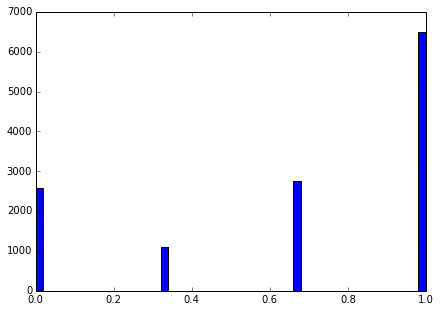

In [306]:
figsize(7,5)
q_scores = list()
for handin in a1_data.handins.itervalues():
    for answer in handin.gradeings.itervalues():
        q_scores.extend(answer.answers.values())
plt.hist(q_scores,bins=50)
plt.show()

In [307]:
a1_gibbs_result = gibbs_model(a1_data,5000,burn_in=1000)

6000 out of 6000
Wall time: 43.349443


In [308]:
a1_gibbs_e_result = gibbs_e_model(a1_data,5000,burn_in=1000)

6000 out of 6000
Wall time: 816.896843


In [309]:
a1_MH_result = MH_model(a1_data,10000,burn_in=1000)

6000 out of 6000
Wall time: 78.792352


In [188]:
def truncate(string,length):
    return (string[:length] + '..') if len(string) > length else string

In [189]:
def handin_students(h_id):
    model_handin = data_model.Handin.objects.get(id=ObjectId(h_id))
    students_ = list()
    for student in model_handin.students:
        students_.append(student.name)
    return ", ".join(students_)

In [318]:
def plot_handins(t,results,nth=1):

    colors = ["#A60628","#348ABD","#7A68A6","#467821","m","c"]
    labels = list()
    for (name,data) in results:
        labels.append(name)
        
    scores = list()
    for id, g in t.handins.iteritems():
        text = id
        val = list()
        for (name,data) in results:
            val.append(np.mean(data['u_h'][id]))
        obs_scores = list()
        for grader in t.handins[id].graders:
            obs_scores.extend(map(lambda x : x[1],t.handins[id].get_grader_answers(grader.id)))
        scores.append((text,val,np.mean(data['u_h'][id]),t.handins[id].mean,obs_scores))
    scores.sort(key=lambda x:x[3]) 
    scores_ = scores[::nth]

    y = xrange(0,len(scores_))
    true_score_ = map(lambda x : x[3],scores_)    
    true_score = map(lambda x : x[3],scores)    
    for i in xrange(len(results)):
        x = map(lambda x : x[1][i],scores)
        x_ = map(lambda x : x[1][i],scores_)
        print "MAE %s: %f" % (labels[i], MAE(true_score,x))
        plt.plot(x_,y,'o',color=colors[i],label=labels[i],alpha=0.65)

    plt.plot(true_score_,y,'x',color='black',label="True score")
    obs_score_ = map(lambda x : x[4],scores_)
    for i, ob in enumerate(obs_score_):
        if i == 0:
            plt.plot(ob,[y[i]]*len(ob),'.',color='gray',alpha=0.1,label="Obs scores")
            plt.plot(np.mean(ob),y[i],'.',color='black',label="Average obs score")
        else:
            plt.plot(ob,[y[i]]*len(ob),'.',color='gray',alpha=0.1)
            plt.plot(np.mean(ob),y[i],'.',color='black')
    obs_score = map(lambda x : x[4],scores)
    print "MAE %s: %f" % ("Observed average score", MAE(true_score,map(lambda x : np.mean(x),obs_score)))
                      
    ylabel = map(lambda x : x[0],scores_)    
    plt.yticks(xrange(0,len(scores)),ylabel)
    leg = plt.legend(numpoints=1,loc=4)
    leg.get_frame().set_alpha(0.4)
    plt.title("Score of the handins")
#    plt.vlines(0, 0, len(scores), color="k", linestyles="--", lw=1)
    plt.ylabel("Handin")
    plt.xlabel("Score")
    plt.margins(0.02)
    plt.show()

In [289]:
def plot_bias(t,results,nth=1):

    colors = ["#A60628","#348ABD","#7A68A6","#467821","m","c"]
    labels = list()
    for (name,data) in results:
        labels.append(name)
        
    scores = list()
    for id, g in t.graders.iteritems():
        text = truncate(user_name(ObjectId(id)),45)
        text = text + ": %i" % len(t.graders[id].handins)
        val = list()
        for (name,data) in results:
            val.append(np.mean(data['u_g'][id]))
        scores.append((text,val,np.mean(data['u_g'][id])))
        
    scores = scores[::nth]
    ax = plt.subplot(111)
    scores.sort(key=lambda x:x[2])
    y = xrange(0,len(scores))
    
    for i in xrange(len(results)):
        x = map(lambda x : x[1][i],scores)
        plt.plot(x,y,'o',color=colors[i],label=labels[i])
    
    ylabel = map(lambda x : x[0],scores)    
    plt.yticks(xrange(0,len(scores)),ylabel)
    leg = plt.legend(numpoints=1,loc=4)
    leg.get_frame().set_alpha(0.4)
    plt.title("Bias of the graders")
    plt.vlines(0, 0, len(scores), color="k", linestyles="--", lw=1)
    plt.ylabel("Grader : [Graded handins]")
    plt.xlabel("Bias")
    plt.show()

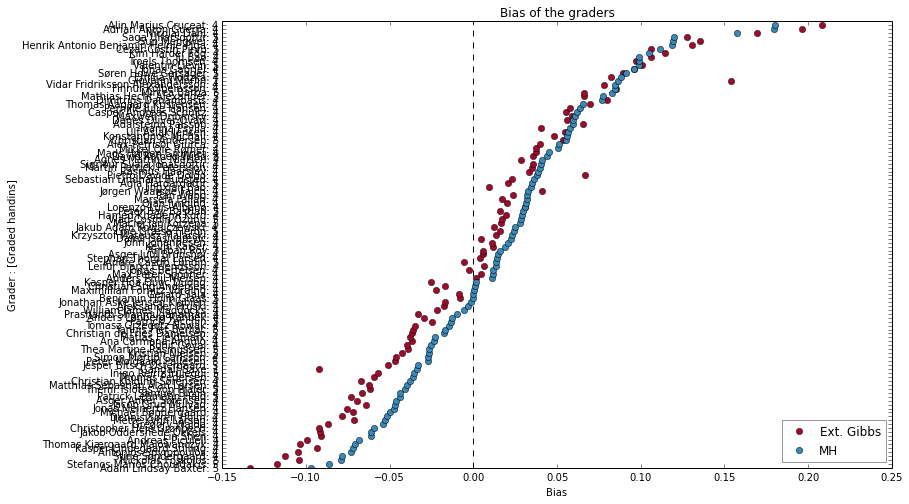

In [315]:
figsize(12,8)
plot_bias(a1_data,[("Ext. Gibbs",a1_gibbs_e_result),("MH",a1_MH_result)],nth=1)

In [319]:
figsize(12,8)
plot_handins(a1_data,[("Ext. Gibbs",a1_gibbs_e_result),("MH",a1_MH_result)],nth=1)

AttributeError: 'list' object has no attribute 'iteritems'